<a href="https://colab.research.google.com/github/RK22000/3Misionaries3Cannibals/blob/main/NibblePadding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nibble Padding
AEDEV1 used benign files to determine padding byte in encrypted file based on prior present in benign files. But this strategy fails if the benign file just does not have the prior bytes.
Nibble Padding or AEDEV2  will split each cipher byte into 2 nibbles and use the benign files to pad each nibble to get 2 bytes. Hopefully the benign files will have all the possible nibbles

In [74]:
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Iterable
from itertools import chain
import random
import math

In [35]:
def nibble_distribution(file: str, figsize: Tuple[int, int] = (12, 5)) -> None:
    nib0: int = 240
    nib1: int = 15
    with open(file=file, mode='rb') as f:
        fbytes: bytes = f.read()
    map0: dict[int, int] = {i: 0 for i in range(15)}
    map1: dict[int, int] = {i: 0 for i in range(15)}
    for byte in fbytes:
        map0[(byte&nib0)>>4] = map0.setdefault((byte&nib0)>>4,0) + 1
        map1[byte&nib1] = map1.setdefault(byte&nib1, 0) + 1
    plt.figure(figsize=figsize)
    plt.subplot(121)
    plt.bar([i for i in map0], map0.values())
    plt.title("Distribution of first nibble")
    for x in map0:
        plt.text(x, map0[x], str(map0[x]), horizontalalignment='center')
    plt.subplot(122)
    plt.title("Distribution of second nibble")
    plt.bar([i for i in map1], map1.values())
    for x in map1:
        plt.text(x, map1[x], str(map1[x]), horizontalalignment='center')

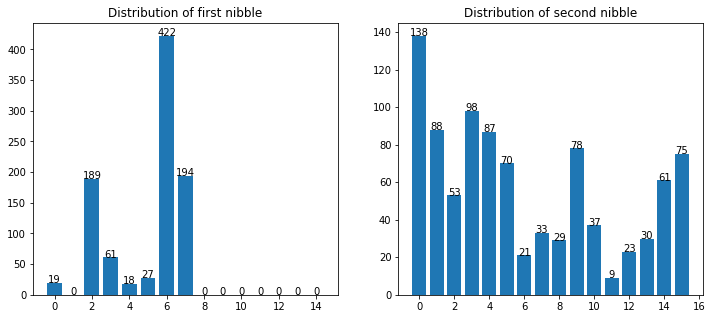

In [36]:
nibble_distribution("/content/sample_data/README.md")

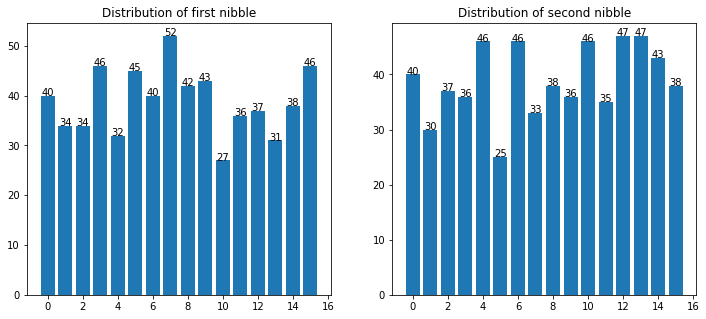

In [37]:
nibble_distribution("/content/sample_data/README.md.gpg")

# Nibble mask

In [66]:
# Nib1 prior
def prior_nib_prob(files: List[str]) -> Dict[int, Tuple[Tuple[int], Tuple[float]]]:
    nib0: int = 240
    nib1: int = 15
    counts: dict[int, dict[int, list[int]]] = {}
    for file in files:
        with open(file=file, mode='rb') as f:
            fbytes = f.read()
        for byte in fbytes:
            key = byte & nib1
            val = (byte & nib0) >> 4
            counts.setdefault(key, {}).setdefault(val, [0])[0]+=1

    probs: dict[int, tuple[tuple[int], tuple[float]]] = {}
    for byte in counts:
        prior_bytes, prior_counts = [[i for i in counts[byte]], [i[0] for i in counts[byte].values()]]
        tot = sum(prior_counts)
        probs[byte] = (tuple(prior_bytes), tuple([i for i in map(lambda i: i/tot, prior_counts)]))
    
    return probs
            

In [67]:
ps = prior_nib_prob(["/content/sample_data/README.md"])
ps

{4: ((5, 6, 7, 3),
  (0.04597701149425287,
   0.3103448275862069,
   0.5977011494252874,
   0.04597701149425287)),
 8: ((6, 2, 7, 3),
  (0.6206896551724138,
   0.1724137931034483,
   0.034482758620689655,
   0.1724137931034483)),
 9: ((6, 7, 3, 4, 2),
  (0.7051282051282052,
   0.11538461538461539,
   0.08974358974358974,
   0.02564102564102564,
   0.0641025641025641)),
 3: ((7, 6, 4, 5, 3),
  (0.5714285714285714,
   0.29591836734693877,
   0.02040816326530612,
   0.061224489795918366,
   0.05102040816326531)),
 0: ((2, 7, 6, 3),
  (0.8115942028985508,
   0.11594202898550725,
   0.043478260869565216,
   0.028985507246376812)),
 2: ((7, 6, 3, 5),
  (0.5471698113207547,
   0.33962264150943394,
   0.09433962264150944,
   0.018867924528301886)),
 5: ((6, 7, 5, 2, 3),
  (0.7571428571428571,
   0.17142857142857143,
   0.014285714285714285,
   0.014285714285714285,
   0.04285714285714286)),
 15: ((6, 5, 2, 4), (0.5066666666666667, 0.12, 0.36, 0.013333333333333334)),
 14: ((6, 2, 4),
  (0.60655

In [68]:
[sum(ps[i][1]) for i in ps]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999999,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999999,
 1.0000000000000002,
 0.9999999999999999,
 1.0,
 1.0]

In [72]:
def nib_mask(encrypted_file: str, probs: Dict[int, Tuple[Tuple[int, ...], Tuple[float, ...]]]) -> None:
    nib0: int = 240
    nib1: int = 15
    with open(file=encrypted_file, mode='rb') as f:
        efbytes = f.read()
    split = chain(*map(lambda byte: ( (byte&nib0)>>4, byte&nib1 ), efbytes))
    masked = map(
        lambda nibble: (random.choices(population=probs[nibble][0],weights=probs[nibble][1],k=1)[0] << 4) | nibble,
        split
    )

    with open(file=encrypted_file+".nibmask", mode='wb') as f:
        f.write(bytes(masked))


In [73]:
nib_mask("/content/sample_data/README.md.gpg", ps)

In [75]:
# Function to get entropy of a list of bytes
def entropy(block: bytes, n: int) -> float:
    byte_map: dict[int, int] = {}
    for byte in block:
        byte_map[byte] = byte_map.setdefault(byte, 0) + 1
    probs = map(lambda x: float(x)/n, byte_map.values())
    entropies = map(lambda p: -p*math.log2(p), probs)
    return sum(entropies)

In [76]:
# Function to display entropy of a file given a specified window size
def file_entropy(file: str, window_size: int, label: str = "") -> None:
    entropies: list[float] = [0.0]
    with open(file=file, mode='rb') as f:
        while True:
            block = f.read(window_size)
            if block==bytes(): break
            #print(block)
            entropies.append(entropy(block=block, n=window_size))
            #print(entropies[-1])
    if label == "":
        label = f"window={window_size}" 
    plt.plot(range(len(entropies)), entropies, label=label)
    #print(entropies)

In [77]:
def file_analyze(
    benign_file: str, 
    encrypted_file: str, 
    masked_file: str = "", 
    sizes = range(10, 40, 8), 
    plt_size: Tuple[int, int] = (8, 6)
    ) -> None:
    """---"""
    
    col = 2 if masked_file=="" else 3
    plt_size = (8, 6)
    plt.figure(figsize=(plt_size[0]*col, plt_size[1]))
    
    plt.subplot(1, col, 1)
    for size in sizes:
        file_entropy(file=benign_file, window_size=size)
    plt.legend()
    plt.title("Unencrypted Entropy")
    plt.subplot(1, col, 2)
    for size in sizes:
        file_entropy(file=encrypted_file, window_size=size)
    plt.legend()
    plt.title("Encrypted Entropy")

    if( col == 3 ):
        plt.subplot(1, col, 3)
        for size in sizes:
            file_entropy(file=masked_file, window_size=size)
        plt.legend()
        plt.title("Masked Entropy")

    plt.suptitle("Plots showing window sizes")




    plt.figure(figsize=(plt_size[0]*len(sizes), plt_size[1]))
    for i, size in enumerate(sizes):
        plt.subplot(1, len(sizes), i+1)
        file_entropy(file=benign_file, window_size=size, label="Unencrypted")
        file_entropy(file=encrypted_file, window_size=size, label="Encrypted")
        if(not masked_file==""):
            file_entropy(file=masked_file, window_size=size, label="Masked")
        plt.legend()
        plt.title(f"window size = {size}")
    plt.suptitle("Plots Comparing encrypted vs unencrypted window size")


In [78]:
sample_file = 'sample_data/README.md'
encrypted_file = 'sample_data/README.md.gpg'

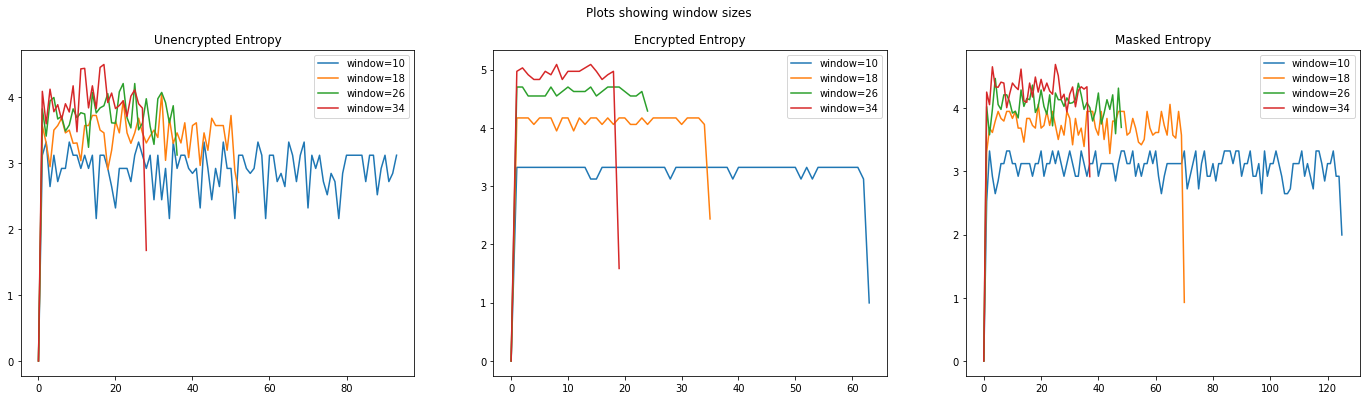

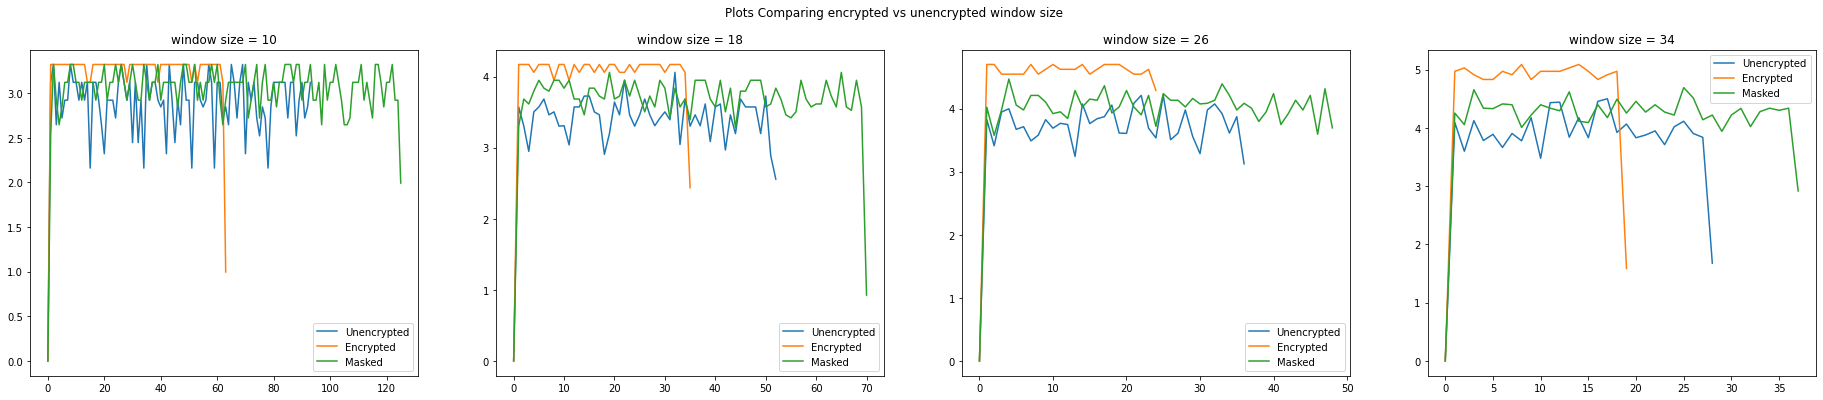

In [79]:
file_analyze(sample_file, encrypted_file, "/content/sample_data/README.md.gpg.nibmask")

In [80]:
def file_visualize(file: str)->None:
    with open(file=file, mode='rb') as f:
        fbytes=f.read()
    plt.scatter([i for i in range(len(fbytes))], list(fbytes), marker='.')

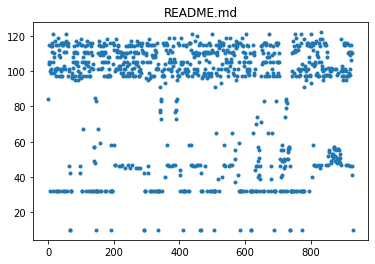

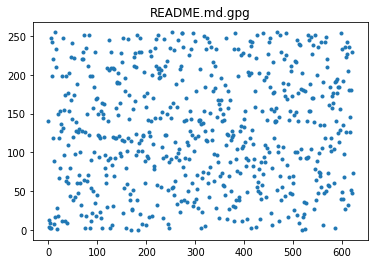

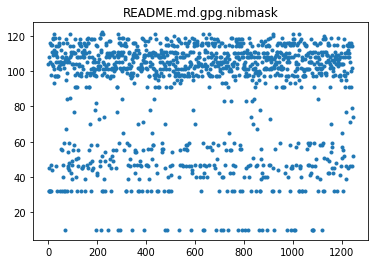

In [81]:
for f in [sample_file, encrypted_file, "/content/sample_data/README.md.gpg.nibmask"]:
    plt.figure()
    plt.title(f.split("/")[-1])
    file_visualize(f)